In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product


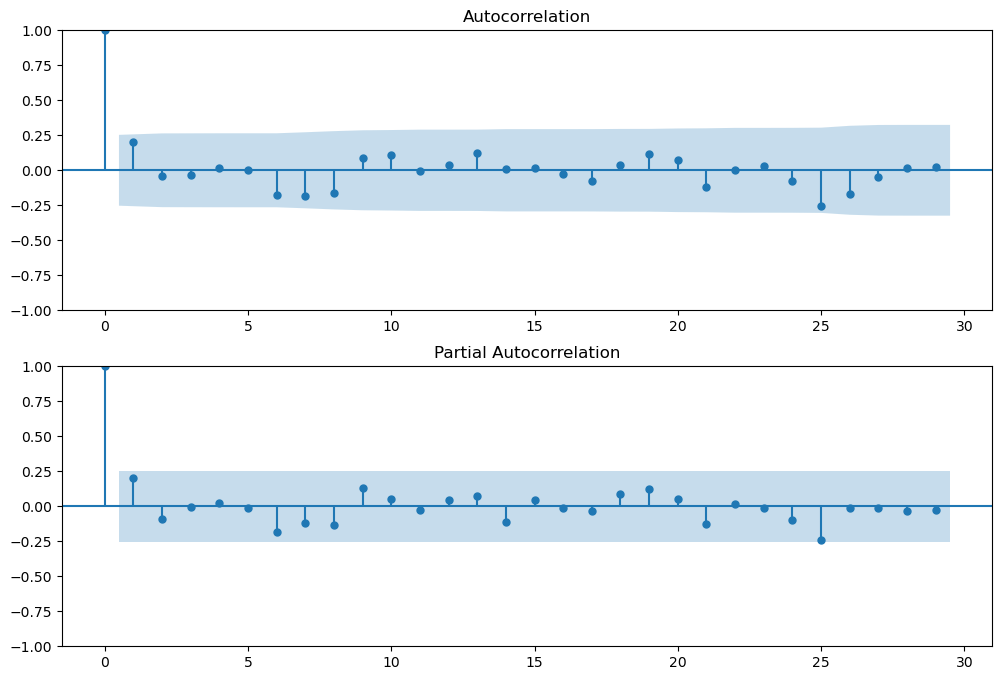

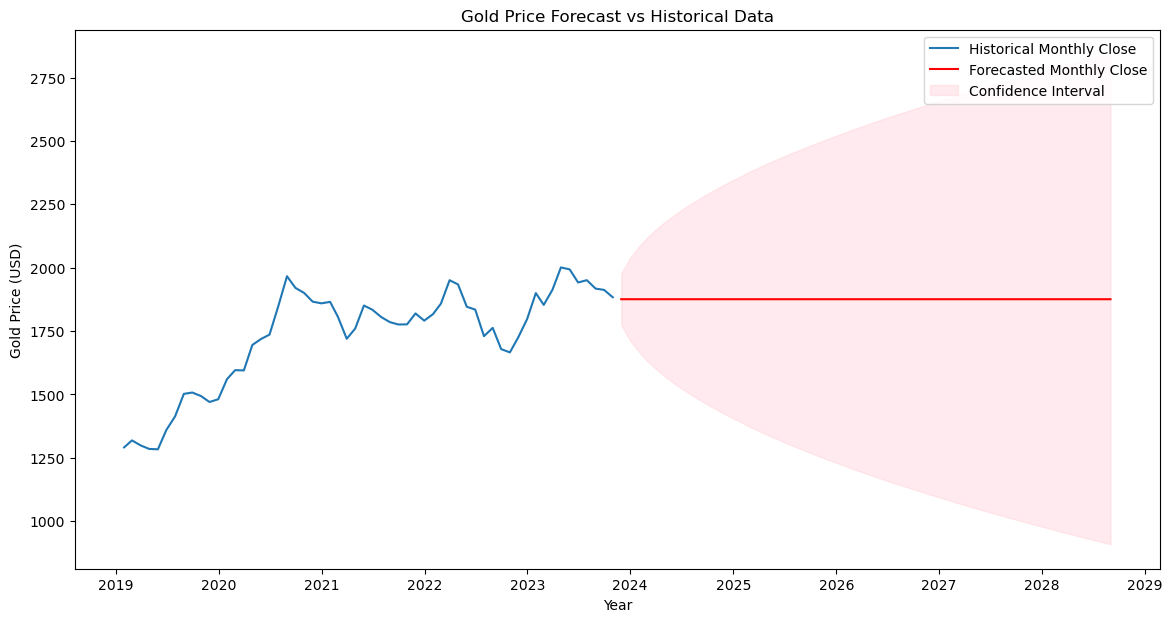

               Forecast    Lower CI     Upper CI
2028-06-30  1875.597187  925.657259  2825.537114
2028-07-31  1875.597187  917.157291  2834.037082
2028-08-31  1875.597187  908.732047  2842.462327


In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Load the data
file_path = 'Dataset/all_commodities_data.csv'  # Update with the correct path
data = pd.read_csv(file_path)

# Data preprocessing
data['date'] = pd.to_datetime(data['date'])
data.sort_values('date', inplace=True)
gold_data = data[data['commodity'] == 'Gold']
last_date = gold_data['date'].max()
five_years_ago = last_date - pd.DateOffset(years=5)
gold_data_last_5_years = gold_data[gold_data['date'] > five_years_ago]
gold_monthly = gold_data_last_5_years.resample('M', on='date').close.mean().dropna()

# Stationarity check and differencing
adf_test = adfuller(gold_monthly)
gold_monthly_diff = gold_monthly.diff().dropna()
adf_test_diff = adfuller(gold_monthly_diff)

# Model selection
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(gold_monthly_diff, ax=ax1, lags=min(len(gold_monthly_diff)//2-1, 40))
plot_pacf(gold_monthly_diff, ax=ax2, lags=min(len(gold_monthly_diff)//2-1, 40))
plt.show()

# Model fitting
arima_model = ARIMA(gold_monthly, order=(1, 1, 1))
arima_result = arima_model.fit()

# Forecasting
forecast_start = '2019-01-31'
forecast_results = arima_result.get_forecast(steps=len(gold_monthly[forecast_start:]), dynamic=True)
forecast_mean = forecast_results.predicted_mean
forecast_conf_int = forecast_results.conf_int()

# Plotting
historical_prices = gold_monthly[forecast_start:]
plt.figure(figsize=(14,7))
plt.plot(historical_prices.index, historical_prices, label='Historical Monthly Close')
plt.plot(forecast_mean.index, forecast_mean, color='red', label='Forecasted Monthly Close')
plt.fill_between(forecast_conf_int.index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.title('Gold Price Forecast vs Historical Data')
plt.xlabel('Year')
plt.ylabel('Gold Price (USD)')
plt.legend()
plt.show()

# Forecast output
forecast_output = forecast_mean.tail(3).to_frame(name='Forecast')
forecast_output['Lower CI'] = forecast_conf_int.tail(3).iloc[:, 0]
forecast_output['Upper CI'] = forecast_conf_int.tail(3).iloc[:, 1]

print(forecast_output)


C:\Users\zhizh\AppData\Local\Temp\ipykernel_4084\537477509.py:22: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  gold_data = gold_data[gold_data['date'] >= pd.to_datetime('now') - pd.DateOffset(years=5)]


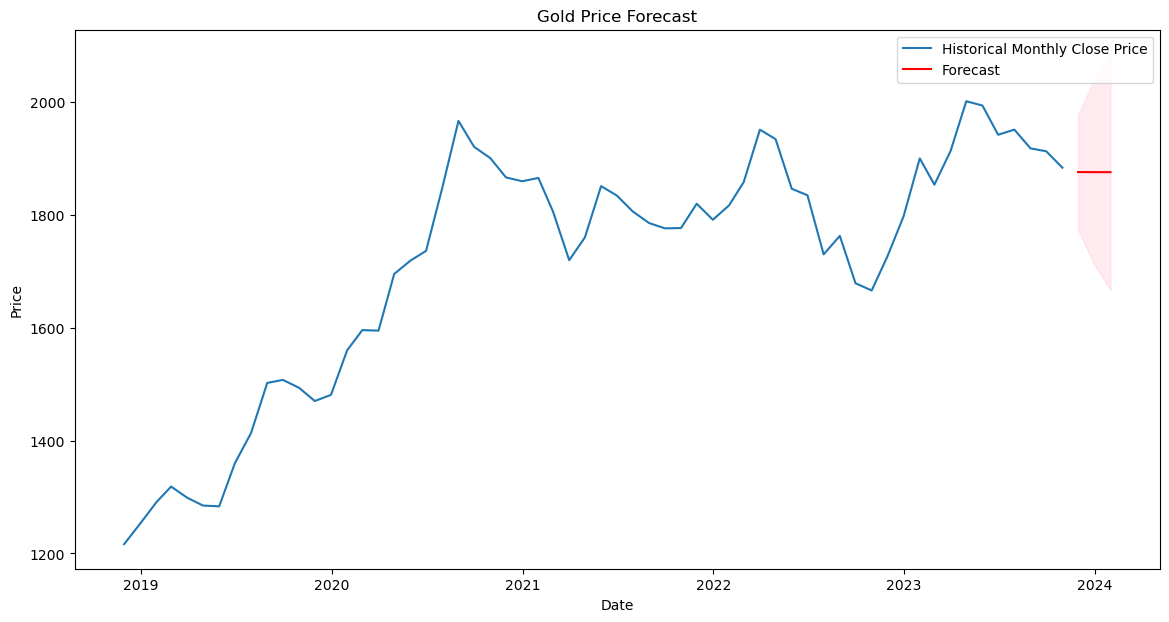

In [45]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Load the data
file_path = 'Dataset/all_commodities_data.csv'
data = pd.read_csv(file_path)

# Preprocessing Steps:
# Convert 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])

# Sort the data chronologically
data.sort_values('date', inplace=True)

# Isolate gold-specific entries and focus on 'close' prices
gold_data = data[data['commodity'] == 'Gold'][['date', 'close']]

# Limit the dataset to the last five years
gold_data = gold_data[gold_data['date'] >= pd.to_datetime('now') - pd.DateOffset(years=5)]

# Resample prices to a monthly frequency, using the average to denote each month's closing price
gold_data.set_index('date', inplace=True)
monthly_gold_data = gold_data.resample('M').mean()

# Stationarity Check using the Augmented Dickey-Fuller test
def check_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    return pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

# Apply the test on the series without differencing
adf_test_result = check_stationarity(monthly_gold_data['close'])

# If non-stationary, apply differencing and re-test
if adf_test_result['p-value'] > 0.05:
    monthly_gold_data['close_diff'] = monthly_gold_data['close'].diff().dropna()
    adf_test_result_diff = check_stationarity(monthly_gold_data['close_diff'].dropna())
else:
    monthly_gold_data['close_diff'] = monthly_gold_data['close']
    adf_test_result_diff = adf_test_result

# Fit the ARIMA(1,1,1) model
model = ARIMA(monthly_gold_data['close'], order=(1, 1, 1))
model_fit = model.fit()

# Forecast the next 3 months
forecast = model_fit.get_forecast(steps=3)
forecast_summary = forecast.summary_frame()

# Extract the forecast and confidence intervals
forecast_values = forecast_summary['mean']
confidence_intervals = forecast_summary[['mean_ci_lower', 'mean_ci_upper']]

# Visualize the historical and forecasted data with confidence intervals
plt.figure(figsize=(14, 7))
plt.plot(monthly_gold_data['close'], label='Historical Monthly Close Price')
plt.plot(forecast_values, label='Forecast', color='red')
plt.fill_between(confidence_intervals.index, 
                 confidence_intervals.iloc[:, 0], 
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Gold Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


C:\Users\zhizh\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


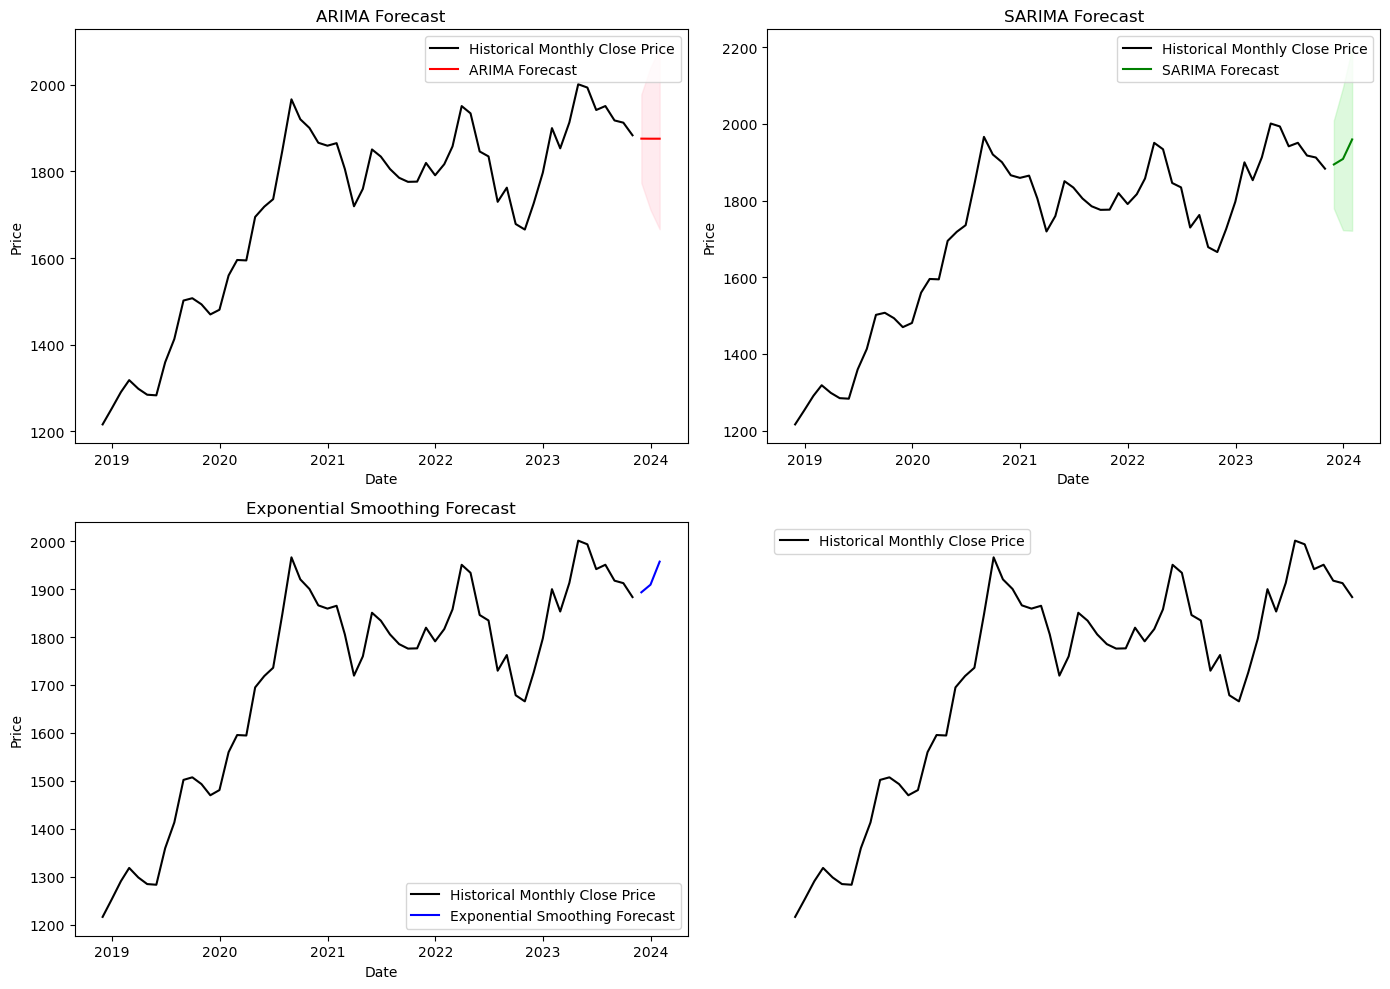

In [46]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit the SARIMA model
sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)  # (P, D, Q, S) - S is the seasonal period length
sarima_model = SARIMAX(monthly_gold_data['close'], order=sarima_order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit()

# Fit the Exponential Smoothing model
exponential_model = ExponentialSmoothing(monthly_gold_data['close'], trend='add', seasonal='add', seasonal_periods=12)
exponential_model_fit = exponential_model.fit()

# Forecasting
sarima_forecast = sarima_model_fit.get_forecast(steps=3)
sarima_forecast_values = sarima_forecast.predicted_mean
sarima_confidence_intervals = sarima_forecast.conf_int()

exponential_forecast_values = exponential_model_fit.forecast(steps=3)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Historical data for all plots
for ax in axes.flatten():
    ax.plot(monthly_gold_data['close'], label='Historical Monthly Close Price', color='black')

# ARIMA plot
axes[0, 0].plot(forecast_values, label='ARIMA Forecast', color='red')
axes[0, 0].fill_between(confidence_intervals.index, 
                        confidence_intervals.iloc[:, 0], 
                        confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
axes[0, 0].set_title('ARIMA Forecast')

# SARIMA plot
axes[0, 1].plot(sarima_forecast_values, label='SARIMA Forecast', color='green')
axes[0, 1].fill_between(sarima_confidence_intervals.index, 
                        sarima_confidence_intervals.iloc[:, 0], 
                        sarima_confidence_intervals.iloc[:, 1], color='lightgreen', alpha=0.3)
axes[0, 1].set_title('SARIMA Forecast')

# Exponential Smoothing plot
axes[1, 0].plot(exponential_forecast_values, label='Exponential Smoothing Forecast', color='blue')
axes[1, 0].set_title('Exponential Smoothing Forecast')

# Empty plot (for placeholder)
axes[1, 1].axis('off')

# Set labels and legends
for ax in axes.flatten():
    if not ax.lines:  # Skip the empty plot
        continue
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend()

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 45ms/step


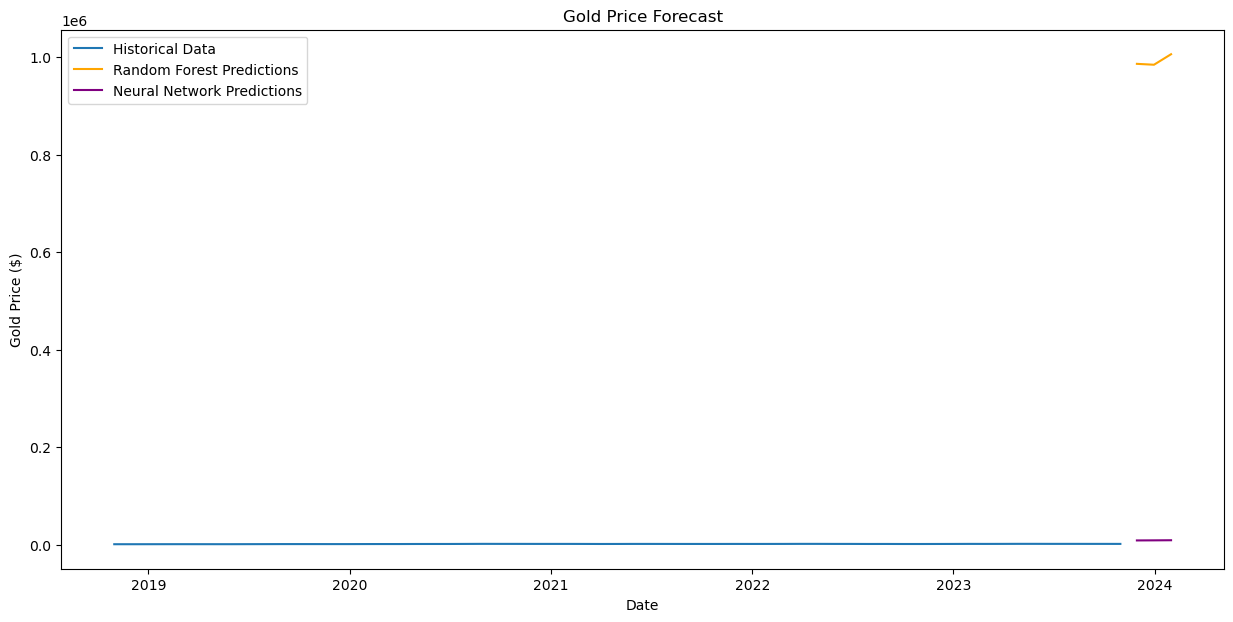

In [47]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('Dataset/all_commodities_data.csv')

# Convert 'date' column to datetime and sort the data chronologically
data['date'] = pd.to_datetime(data['date'])
data.sort_values('date', inplace=True)

# Isolate gold-specific entries and focus on 'close' prices for the last five years
gold_data = data[data['commodity'] == 'Gold'][['date', 'close']]
gold_data = gold_data[gold_data['date'] >= (gold_data['date'].max() - pd.DateOffset(years=5))]

# Resample prices to a monthly frequency, using the average to denote each month's closing price
gold_data.set_index('date', inplace=True)
monthly_gold_data = gold_data['close'].resample('M').mean()

# Creating lagged features for the last 12 months
lag = 12
features = pd.concat([monthly_gold_data.shift(i) for i in range(lag, 0, -1)], axis=1)
features = features.dropna()

# Define the target and features
X = features.values
y = monthly_gold_data[lag:].values

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Fit the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_scaled[:-3, :], y[:-3])  # leave out the last 3 months

# Predict the next 3 months with the Random Forest model
rf_predictions = []
for i in range(1, 4):
    last_scaled_features = scaler.transform(features.iloc[-i:].values)
    rf_prediction = rf_model.predict(last_scaled_features)
    rf_predictions.append(rf_prediction[0])

# Convert the list of predictions to a numpy array
rf_predictions_array = np.array(rf_predictions).reshape(-1, 1)

# Create a dummy feature array for inverse transformation for the Random Forest model
dummy_rf_features = np.zeros((len(rf_predictions), X_scaled.shape[1]))
dummy_rf_features[:, -1] = rf_predictions_array[:, 0]

# Inverse transform to get the predictions to the original scale for the Random Forest model
rf_predictions_original = scaler.inverse_transform(dummy_rf_features)[:, -1]

# Fit the Neural Network model
nn_model = Sequential()
nn_model.add(Dense(100, activation='relu', input_shape=(lag,)))
nn_model.add(Dense(1))
nn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
nn_model.fit(X_scaled[:-3, :], y[:-3], epochs=50, verbose=0)

# Predict the next 3 months with the Neural Network
nn_predictions = nn_model.predict(X_scaled[-3:, :]).flatten()

# Create a dummy feature array for inverse transformation for the Neural Network model
dummy_nn_features = np.zeros((len(nn_predictions), X_scaled.shape[1]))
dummy_nn_features[:, -1] = nn_predictions

# Inverse transform to get the predictions to the original scale for the Neural Network model
nn_predictions_original = scaler.inverse_transform(dummy_nn_features)[:, -1]

# Plotting
dates = monthly_gold_data.index
forecast_dates = pd.date_range(start=dates[-1], periods=4, freq='M')[1:]

plt.figure(figsize=(15, 7))

# Plot historical data
plt.plot(dates, monthly_gold_data, label='Historical Data')

# Plot Random Forest predictions
plt.plot(forecast_dates, rf_predictions_original, label='Random Forest Predictions', color='orange')

# Plot Neural Network predictions
plt.plot(forecast_dates, nn_predictions_original, label='Neural Network Predictions', color='purple')

plt.title('Gold Price Forecast')
plt.xlabel('Date')
plt.ylabel('Gold Price ($)')
plt.legend()
plt.show()


In [48]:
# After inverse transforming the predictions
print("Scaled RF Predictions:", rf_predictions_array)
print("Original scale RF Predictions:", rf_predictions_original)

print("Scaled NN Predictions:", nn_predictions)
print("Original scale NN Predictions:", nn_predictions_original)


Scaled RF Predictions: [[1854.76078666]
 [1851.30095061]
 [1891.91718329]]
Original scale RF Predictions: [ 986435.81395616  984598.47716598 1006167.62019059]
Scaled NN Predictions: [14.154944 14.48616  14.907238]
Original scale NN Predictions: [8986.94583127 9162.83713756 9386.44935232]


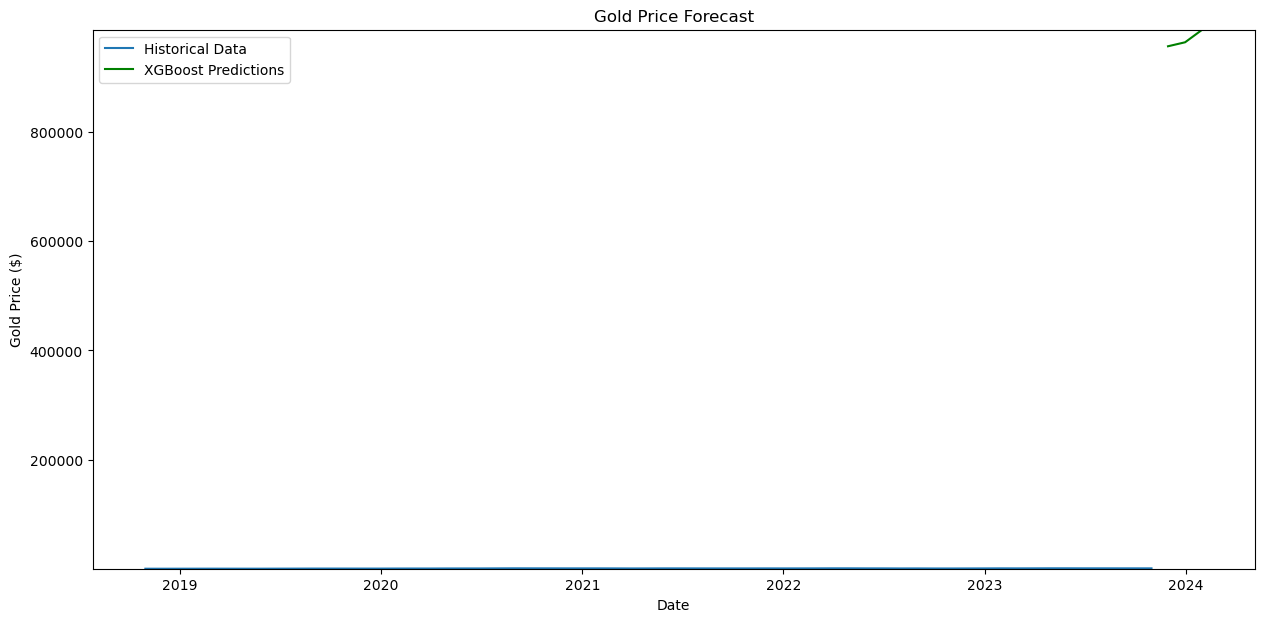

In [53]:
import xgboost as xgb

# Prepare the data in DMatrix format which is optimized for XGBoost
train_data = xgb.DMatrix(X_scaled[:-3, :], label=y[:-3])

# Define XGBoost model parameters
params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

# Number of boosting rounds
num_boost_round = 100

# Train the model
xgb_model = xgb.train(params, train_data, num_boost_round)

# Predict the next 3 months with the XGBoost model
xgb_predictions = []
for i in range(1, 4):
    # Get the last i-th month's scaled features as a single-row array
    last_scaled_features = scaler.transform(features.iloc[-i].values.reshape(1, -1))
    # Predict using the model and get a single value
    xgb_prediction = xgb_model.predict(xgb.DMatrix(last_scaled_features))
    # Append the prediction to the list
    xgb_predictions.append(xgb_prediction[0])  # Take the first element to get a scalar

# Convert the list of predictions to a numpy array
xgb_predictions_array = np.array(xgb_predictions).reshape(-1, 1)

# Create a dummy feature array for inverse transformation for the XGBoost model
dummy_xgb_features = np.zeros((3, X_scaled.shape[1]))
dummy_xgb_features[:, -1] = xgb_predictions_array[:, 0]

# Inverse transform to get the predictions to the original scale for the XGBoost model
xgb_predictions_original = scaler.inverse_transform(dummy_xgb_features)[:, -1]

# Plotting
plt.figure(figsize=(15, 7))

# Plot historical data
plt.plot(dates, monthly_gold_data, label='Historical Data')

# Plot XGBoost predictions
forecast_dates = pd.date_range(start=dates[-1], periods=4, freq='M')[1:]
plt.plot(forecast_dates, xgb_predictions_original, label='XGBoost Predictions', color='green')

# Set the y-axis to have the same scale as the original gold prices
plt.ylim(ymin=monthly_gold_data.min(), ymax=max(monthly_gold_data.max(), xgb_predictions_original.max()))

plt.title('Gold Price Forecast')
plt.xlabel('Date')
plt.ylabel('Gold Price ($)')
plt.legend()
plt.show()

